# Imports

In [1]:
import argparse, pdb
import numpy as np
import os
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from typing import Callable
import matplotlib.pyplot as plt
from torch import tensor
import cv2

In [2]:
# Define some useful hyperparameters
IMG_SIZE = 299
device = "cuda" if torch.cuda.is_available() else "cpu"
LABELS = ["cat", "dog", "neg"]

train_image_dir = "./datasets/train"
test_image_dir = "./datasets/test"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),            # Resize to dimensions for Inception network
    transforms.ToTensor(),                              # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# See https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html for
# more details on usage.
train_img_folder = torchvision.datasets.ImageFolder(root=train_image_dir, transform=transform)

def to_numpy(tensor):
  return tensor.detach().cpu().numpy()

train_embs, train_labels = [], []
print('number of train images: ', len(train_img_folder))

######### Your code starts here #########
# Load the pretrained model 
model = models.inception_v3(pretrained=True)
# Remove the last layer
model.AuxLogits = None
model = nn.Sequential(*list(model.children())[:-1])
model.append(nn.Flatten())
model.eval()
model.to(device)

for images, labels in tqdm.tqdm(train_img_folder):
    images = images.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(images)
    train_embs.append(output)
    train_labels.append(labels)

######### Your code ends here #########

train_embs = torch.from_numpy(np.concatenate(train_embs))
train_labels = torch.Tensor(train_labels)
train_dataset = TensorDataset(train_embs, train_labels)

number of train images:  450


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 450/450 [00:28<00:00, 15.78it/s]


# Section 2: Train linear classifier

In [3]:
# Define some training hyperparameters, feel free to modify these
num_epochs = 30
lr = 1e-3
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

######### Your code starts here #########
# We want to create a linear classifier which takes the embedding vectors as input.
# The training loop is already provided for you.

# 1. Define a new torch module for the classifier.
# 2. Define an appropriate optimizer from torch.optim.
# 3. Define the loss function for training the classifier.
# 4. Train the classifier for num_epochs epochs.

class LinearClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

linear_classifier = LinearClassifier(2048, 3)
linear_classifier.to(device)

optimizer = optim.Adam(linear_classifier.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

######### Your code ends here #########

for epoch in range(num_epochs):
  # set model to training mode
  linear_classifier.train()
  train_loss = 0

  for batch_idx, (embeddings, class_label) in enumerate(train_loader):
    embeddings = embeddings.reshape(-1,2048).to(device)
    class_label = class_label.to(device)

    optimizer.zero_grad()

    probs = linear_classifier(embeddings)
    loss = loss_fn(probs, class_label.long())

    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader)))


Epoch: 0 Average loss: 0.9389
Epoch: 1 Average loss: 0.5866
Epoch: 2 Average loss: 0.5038
Epoch: 3 Average loss: 0.4115
Epoch: 4 Average loss: 0.3310
Epoch: 5 Average loss: 0.3009
Epoch: 6 Average loss: 0.2481
Epoch: 7 Average loss: 0.2202
Epoch: 8 Average loss: 0.3194
Epoch: 9 Average loss: 0.1859
Epoch: 10 Average loss: 0.2292
Epoch: 11 Average loss: 0.1718
Epoch: 12 Average loss: 0.1519
Epoch: 13 Average loss: 0.1454
Epoch: 14 Average loss: 0.1380
Epoch: 15 Average loss: 0.1293
Epoch: 16 Average loss: 0.1458
Epoch: 17 Average loss: 0.1192
Epoch: 18 Average loss: 0.1214
Epoch: 19 Average loss: 0.1080
Epoch: 20 Average loss: 0.1004
Epoch: 21 Average loss: 0.1012
Epoch: 22 Average loss: 0.1114
Epoch: 23 Average loss: 0.1076
Epoch: 24 Average loss: 0.1996
Epoch: 25 Average loss: 0.1308
Epoch: 26 Average loss: 0.0858
Epoch: 27 Average loss: 0.0825
Epoch: 28 Average loss: 0.0718
Epoch: 29 Average loss: 0.0866


# Section 3: Classify test images

In [4]:
IMG_SIZE = 299
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),            # Resize to dimensions for Inception network
    transforms.ToTensor(),                              # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load the test dataset
test_dataset = torchvision.datasets.ImageFolder(root=test_image_dir, transform=transform)

######### Your code starts here #########
# Classify all images in the test image folder
# Calculate the accuracy of the model on all of the images.
# You should be able to get > 90% accuracy.

test_embs, test_labels = [], []
print('number of test images: ', len(test_dataset))

for images, labels in tqdm.tqdm(test_dataset):
    images = images.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(images)
    test_embs.append(output)
    test_labels.append(labels)

test_embs = torch.from_numpy(np.concatenate(test_embs))
test_labels = torch.Tensor(test_labels)
test_dataset = TensorDataset(test_embs, test_labels)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

linear_classifier.eval()
test_loss = 0
test_acc = 0
indices_where_False = np.array([])
predicted_labels = np.array([])
for batch_idx, (embeddings, class_label) in enumerate(test_loader):
    embeddings = embeddings.to(device)
    class_label = class_label.to(device)

    probs = linear_classifier(embeddings)
    loss = loss_fn(probs, class_label.long())

    test_loss += loss.item()
    test_acc += (probs.argmax(1) == class_label).sum().item()
    indices_where_False = np.concatenate((indices_where_False,np.where(probs.argmax(1) != class_label)[0]+batch_idx*batch_size))
    predicted_labels = np.concatenate((predicted_labels,probs.argmax(1)[probs.argmax(1) != class_label]))
test_loss /= len(test_loader)
test_acc /= len(test_dataset)

######### Your code ends here #########

print(f"Evaluated on {len(test_dataset)} samples.")
print(f"Accuracy: {test_acc * 100:.0f}%")
print('Wrong Predictions: ', indices_where_False)

number of test images:  150


100%|██████████| 150/150 [00:09<00:00, 16.44it/s]

Evaluated on 150 samples.
Accuracy: 92%
Wrong Predictions:  [ 30.  48.  59.  66.  75.  97. 110. 122. 123. 132. 134. 140.]


In the next cell, I print the file names for the missclassified images:

In [5]:
test_dataset = torchvision.datasets.ImageFolder(root=test_image_dir, transform=transform)
c = 0
for idx in indices_where_False:
    
    # Get the image filename corresponding to the index
    filename = test_dataset.samples[int(idx)]
    print(f"Filename for index {idx}: {filename}",f"Predicted label: {LABELS[int(predicted_labels[int(c)])]}")
    c += 1

Filename for index 30.0: ('./datasets/test/cat/005960.jpg', 0) Predicted label: dog
Filename for index 48.0: ('./datasets/test/cat/009479.jpg', 0) Predicted label: dog
Filename for index 59.0: ('./datasets/test/dog/001234.jpg', 1) Predicted label: neg
Filename for index 66.0: ('./datasets/test/dog/003228.jpg', 1) Predicted label: neg
Filename for index 75.0: ('./datasets/test/dog/005081.jpg', 1) Predicted label: neg
Filename for index 97.0: ('./datasets/test/dog/008890.jpg', 1) Predicted label: cat
Filename for index 110.0: ('./datasets/test/neg/002193.jpg', 2) Predicted label: dog
Filename for index 122.0: ('./datasets/test/neg/004735.jpg', 2) Predicted label: dog
Filename for index 123.0: ('./datasets/test/neg/004831.jpg', 2) Predicted label: cat
Filename for index 132.0: ('./datasets/test/neg/006718.jpg', 2) Predicted label: dog
Filename for index 134.0: ('./datasets/test/neg/007991.jpg', 2) Predicted label: dog
Filename for index 140.0: ('./datasets/test/neg/008879.jpg', 2) Predict

# Section 4: Object Detection

In [6]:
def compute_brute_force_classification(
    model: nn.Module,
    raw_img: np.ndarray,
    transforms,
    nH: int = 8,
    nW: int = 8,
):
    '''
    This function returns the probabilities of each window.
    Inputs:
        model: Model which is used
        raw_img: H x W x 3 numpy array
        transforms: a sequence of transformations to apply to the image as preprocessing
        nH: number of windows in the vertical direction
        nW: number of windows in the horizontal direction
    Outputs:
        window_predictions: a (nH, nW, 3) np.array.
                            The last dim (size 3) is the probabilities
                            of each label (cat, dog, neg)
    '''


    ######### Your code starts here #########
    linear_classifier.eval()
    temprature = 0.5
    window_predictions = np.zeros((nH, nW, 3))
    overlap_factor = 0.5 # Adjust this value to control the overlap, e.g., 0.5 means 50% overlap
    img = raw_img

    H, W, _ = img.shape
    patch_height = (H + (nH - 1) * (H // nH)) // nH
    patch_width = (W + (nW - 1) * (W // nW)) // nW
    step_size_i = int(patch_height * (1 - overlap_factor))
    step_size_j = int(patch_width * (1 - overlap_factor))


    for i in range(nH):
        for j in range(nW):
            start_i = i * step_size_i
            end_i = start_i + patch_height
            start_j = j * step_size_j
            end_j = start_j + patch_width

            patch = img[start_i:end_i, start_j:end_j, :]
            windows = transforms(patch).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(windows).reshape(-1,2048)
                window_predictions[i,j] = torch.nn.functional.softmax(linear_classifier(output)/temprature,dim=1).cpu().numpy()

    ######### Your code ends here #########

    return window_predictions

In [7]:
def plot_classification(raw_img, classification_array):
    nH, nW, _ = classification_array.shape
    aspect_ratio = float(raw_img.shape[0]) / raw_img.shape[1]
    plt.figure(figsize=(8, 8*aspect_ratio))
    p1 = plt.subplot(2,2,1)
    plt.imshow(classification_array[:,:,0], interpolation='none', cmap='jet')
    plt.title('%s probability' % LABELS[0])
    p1.set_aspect(aspect_ratio*nW/nH)
    plt.colorbar()
    p2 = plt.subplot(2,2,2)
    plt.imshow(classification_array[:,:,1], interpolation='none', cmap='jet')
    plt.title('%s probability' % LABELS[1])
    p2.set_aspect(aspect_ratio*nW/nH)
    plt.colorbar()
    p2 = plt.subplot(2,2,3)
    plt.imshow(classification_array[:,:,2], interpolation='none', cmap='jet')
    plt.title('%s probability' % LABELS[2])
    p2.set_aspect(aspect_ratio*nW/nH)
    plt.colorbar()
    plt.subplot(2,2,4)
    plt.imshow(raw_img)
    plt.savefig("detect.png")
    plt.show()

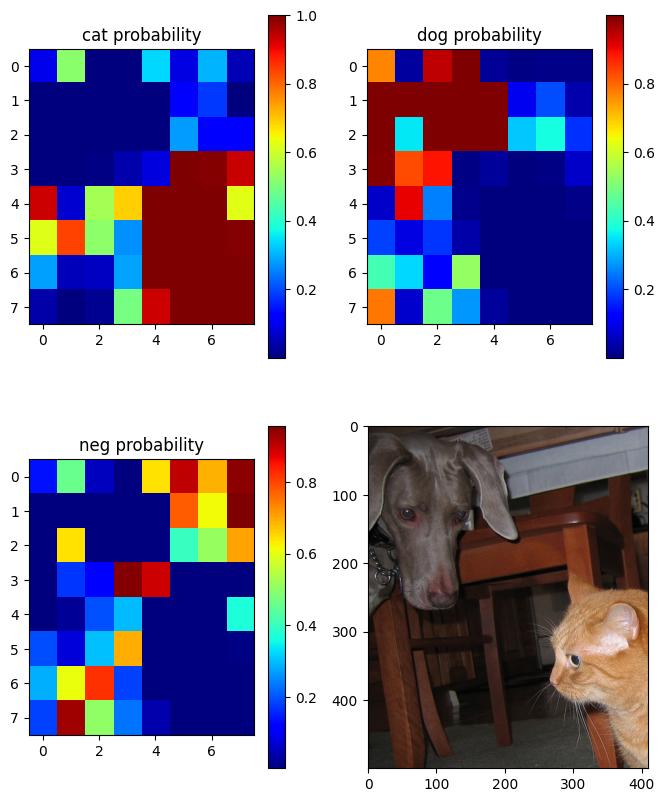

In [8]:
# Get raw image using PIL

catswithdogs_dir = "datasets/catswithdogs"
raw_img = np.array(Image.open(os.path.join(catswithdogs_dir, "001211.jpg")))
def custom_padding(img):
    return transforms.functional.pad(img, (5, 5, 5, 5))

IMG_SIZE = 299
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),                  # Numpy array to PIL Image first
    custom_padding,                           # Pad the image
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to dimensions for Inception network
    transforms.ToTensor(),                    # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

model = models.inception_v3(pretrained=True)
model.AuxLogits = None
model = torch.nn.Sequential(*list(model.children())[:-1])
model.append(torch.nn.Flatten())
model.eval()


window_predictions = compute_brute_force_classification(
    model= model ,
    raw_img=raw_img,
    transforms=transform,
)

plot_classification(raw_img, window_predictions)

In [9]:

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        model.AuxLogits = None
        model.eval()
        self.features = nn.Sequential(*list(model.children())[:-3])

    def forward(self, x):
        x = self.features(x)
        return x

model = torchvision.models.inception_v3(pretrained=True)
model = FeatureExtractor(model=model)   



In [10]:
def compute_convolutional_KxK_classification(
    model: nn.Module,
    raw_img: np.ndarray,
    transforms
):
    """
    Computes probabilities for each window based on the convolution layer of Inception
    Inputs:
      model: model which is used
      raw_img: numpy array of image

    Outputs:
      predictions: a (K, K, 3) np.array.
    """
    transformed_img = transforms(raw_img)
    linear_classifier.eval()

    ######### Your code starts here #########
    # 1. Preprocess the image using the transforms
    # 2. Run the image through the model and get the convolutional features
    # 3. Compute the probabilities for each window
    # 4. Return the probabilities in the shape of (K, K, 3) 
    predictions = torch.zeros((8,8,3))
    temp = 0.5
    img = transformed_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        output = output.squeeze(0)
        for i in range(8):
            for j in range(8):
                predictions[i,j,:] = torch.nn.functional.softmax(linear_classifier(output[:,i,j].reshape(-1,2048))/temp,dim=1)
        predictions = predictions.cpu().numpy()

    ######### Your code ends here #########

    return predictions

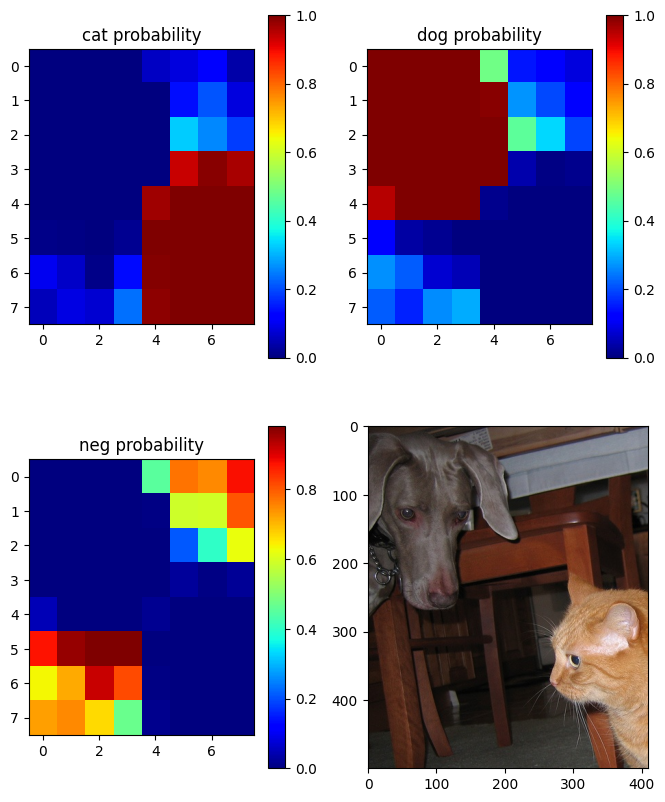

In [11]:
# Get raw image, do not apply transform
catswithdogs_dir = "./datasets/catswithdogs"
raw_img = np.array(Image.open(os.path.join(catswithdogs_dir, "001211.jpg")))
IMG_SIZE = 299
transform = transforms.Compose([
    transforms.ToPILImage(),                  # Numpy array to PIL Image first
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to dimensions for Inception network
    transforms.ToTensor(),                    # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
transformed_img = transform(raw_img)
c = model(transformed_img.unsqueeze(0).to(device))

window_predictions = compute_convolutional_KxK_classification(
    model= model,
    raw_img=raw_img,
    transforms=transform,
)

plot_classification(raw_img, window_predictions)
     

# Section 5: Saliency Mapping

In [12]:
def compute_and_plot_saliency(
    model: nn.Module,
    raw_img: np.ndarray
):
    """
    This function computes and plots the saliency plot.
    You need to compute the matrix M detailed in section 3.1 in
    K. Simonyan, A. Vedaldi, and A. Zisserman,
    "Deep inside convolutional networks: Visualising imageclassification models and saliency maps,"
    2013, Available at https://arxiv.org/abs/1312.6034.

    Inputs:
      model: model which is used
      raw_img: numpy array of image
    """
    ######### Your code starts here #########
    for param in model.parameters():
        param.requires_grad = False
    
    img = raw_img

    model.eval()
    linear_classifier.eval()
    input = transform(img)
    input.unsqueeze_(0)

    input.requires_grad = True
    preds = model(input)
    score, index = torch.max(preds, 1)

    score.backward()

    M, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    M = (M - M.min())/(M.max()-M.min())

    model.fc = torch.nn.Identity()
    top_class = linear_classifier(model(input)).argmax(1).item()
    

    ######### Your code ends here #########

    # Code to save the saliency plot
    plt.subplot(2, 1, 1)
    plt.imshow(M)
    plt.title('Saliency with respect to predicted class %s' % LABELS[top_class])
    plt.subplot(2, 1, 2)
    plt.imshow(raw_img)
    plt.savefig("saliency.png")
    plt.show()


Correctly classified saliency map:

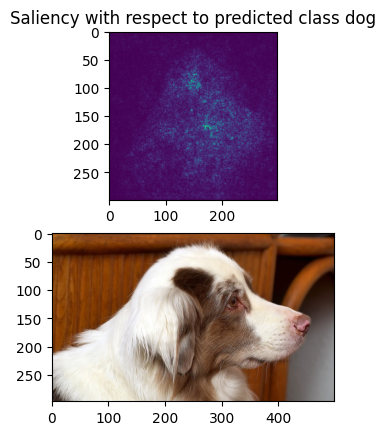

In [13]:
# Get raw image, do not apply transform
img_dir = "./datasets/test/dog"
raw_img = np.array(Image.open(os.path.join(img_dir, "000454.jpg")))

compute_and_plot_saliency(
    model = torchvision.models.inception_v3(pretrained=True, aux_logits=True),
    raw_img = raw_img
)

Wrongly classified saliency map:

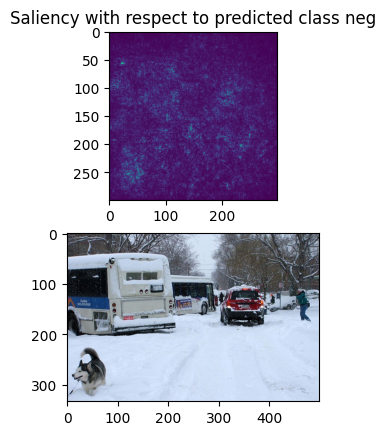

In [14]:
img_dir = "./datasets/test/dog"
raw_img = np.array(Image.open(os.path.join(img_dir, "003228.jpg")))

compute_and_plot_saliency(
    model = torchvision.models.inception_v3(pretrained=True, aux_logits=True),
    raw_img = raw_img
)
